As for now, we can create only shap values for models with ecy as a feature. Base margine is not taken into account in shap package

In [75]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import os
import shap
import matplotlib.pyplot as pl

In [76]:
shap.initjs()

In [77]:
ModelsDir = '/home/kate/Research/Property/Models/'
DataDir = '/home/kate/Research/Property/Data/'

In [78]:
training_classification_dataset = pd.read_csv('%sproperty_wcf_class_training.csv'%DataDir, error_bad_lines=False, index_col=False)
training_poisson_dataset = pd.read_csv('%sproperty_wcf_training.csv'%DataDir, error_bad_lines=False, index_col=False)

In [79]:
Model_Classification = 'wc_class_f_ecy_XGB_0'
Model_Poisson = 'wc_Poisson_f_ecy_XGB_0'

In [121]:
prediction_column_classification = 'class_f_ecy_cv_xgb'
prediction_column_poisson = 'poisson_f_ecy_cv_xgb'

In [81]:
featureset  = [
 'cova_deductible',
 'roofcd_encd',
 'sqft',
 'usagetype_encd',
 'yearbuilt',
 'cova_limit',
 'water_risk_fre_3_blk',
 'water_risk_3_blk',
 'ecy'
]

In [82]:
#
X_classification=training_classification_dataset[featureset]
Dtrain_classification = xgb.DMatrix(X_classification.values)
#
X_poisson=training_poisson_dataset[featureset]
Dtrain_poisson = xgb.DMatrix(X_poisson.values)

In [83]:
xgb_model_file='%s%s.model'%(ModelsDir,Model_Classification)
xgb_model_Classification = pickle.load(open(xgb_model_file, 'rb'))
#
xgb_model_file='%s%s.model'%(ModelsDir,Model_Poisson)
xgb_model_Poisson = pickle.load(open(xgb_model_file, 'rb'))

## Explain the models

In [84]:
explainer_Classification = shap.TreeExplainer(xgb_model_Classification)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [85]:
explainer_Poisson = shap.TreeExplainer(xgb_model_Poisson)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


SHAP values sum to the difference between the expected output of the model and the current output for the current player. Note that for the Tree SHAP implmementation the margin output of the model is explained, not the trasformed output (such as a probability for logistic regression). This means that the units of the SHAP values for this model are log odds ratios. Large positive values mean a player is likely to win, while large negative values mean they are likely to lose.

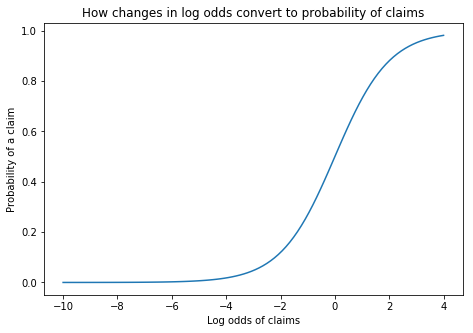

In [86]:
xs = np.linspace(-10,4,100)
pl.xlabel("Log odds of claims")
pl.ylabel("Probability of a claim")
pl.title("How changes in log odds convert to probability of claims")
pl.plot(xs, 1/(1+np.exp(-xs)))
pl.show()

In [87]:
shap_values_Classification = explainer_Classification.shap_values(Dtrain_classification)

In [88]:
df_shap_values_Classification = pd.DataFrame(data=shap_values_Classification,   columns=featureset)
df_shap_values_Classification['original_output_value'] = df_shap_values_Classification.sum(axis=1)
df_shap_values_Classification['expected_value'] = explainer_Classification.expected_value
df_shap_values_Classification['output_value'] = df_shap_values_Classification['expected_value'] + df_shap_values_Classification['original_output_value']

In [89]:
df_shap_values_Classification.to_csv('%sshap_values_Classification.csv'%DataDir,header=True,index=False)

In [90]:
shap_values_Poisson = explainer_Poisson.shap_values(Dtrain_poisson)

In [91]:
df_shap_values_Poisson = pd.DataFrame(data=shap_values_Poisson,   columns=featureset)
df_shap_values_Poisson['original_output_value'] = df_shap_values_Poisson.sum(axis=1)
df_shap_values_Poisson['expected_value'] = explainer_Poisson.expected_value
df_shap_values_Poisson['output_value'] = df_shap_values_Poisson['expected_value'] + df_shap_values_Poisson['original_output_value']

In [92]:
df_shap_values_Poisson.to_csv('%sshap_values_Poisson.csv'%DataDir,header=True,index=False)

In [122]:
training_classification_dataset[training_dataset[prediction_column_classification]==training_classification_dataset[prediction_column_classification].min()].head(1)

,cova_deductible,roofcd,roofcd_encd,sqft,log_sqft,usagetype,usagetype_encd,yearbuilt,log_yearbuilt,cova_limit,...,class_bm_ecy_xgb_fold_1,class_bm_ecy_xgb_fold_2,class_bm_ecy_xgb_fold_3,class_bm_ecy_xgb_fold_4,class_f_ecy_cv_xgb,class_f_ecy_xgb_fold_0,class_f_ecy_xgb_fold_1,class_f_ecy_xgb_fold_2,class_f_ecy_xgb_fold_3,class_f_ecy_xgb_fold_4
544369,1000,COMPO,8,1100,7.003065,COC,5,1915,7.557473,300000,...,0.000002,0.000002,0.000003,0.000002,0.000033,0.000025,0.000034,0.00002,0.000083,0.000005


In [123]:
shap.force_plot(explainer_Classification.expected_value, shap_values_Classification[544369,:], X_classification.iloc[544369,:])

In [124]:
training_poisson_dataset[training_poisson_dataset[prediction_column_poisson]==training_poisson_dataset[prediction_column_poisson].min()].head(1)

,cova_deductible,roofcd,roofcd_encd,sqft,log_sqft,usagetype,usagetype_encd,yearbuilt,log_yearbuilt,cova_limit,...,poisson_f_ecy_xgb_fold_1,poisson_f_ecy_xgb_fold_2,poisson_f_ecy_xgb_fold_3,poisson_f_ecy_xgb_fold_4,cova_ic_nc_water_cv_pred,cova_ic_nc_water_pred_0,cova_ic_nc_water_pred_1,cova_ic_nc_water_pred_2,cova_ic_nc_water_pred_3,cova_ic_nc_water_pred_4
653074,1000,COMPO,8,800,6.684612,VACANT,4,1915,7.557473,200000,...,0.000133,0.000103,0.000087,0.00008,0.000107,0.000074,0.000111,0.000127,0.000095,0.000127


In [125]:
shap.force_plot(explainer_Poisson.expected_value, shap_values_Poisson[653074,:], X_poisson.iloc[653074,:])

In [126]:
training_classification_dataset[training_dataset[prediction_column_classification]==training_classification_dataset[prediction_column_classification].max()].head(1)

,cova_deductible,roofcd,roofcd_encd,sqft,log_sqft,usagetype,usagetype_encd,yearbuilt,log_yearbuilt,cova_limit,...,class_bm_ecy_xgb_fold_1,class_bm_ecy_xgb_fold_2,class_bm_ecy_xgb_fold_3,class_bm_ecy_xgb_fold_4,class_f_ecy_cv_xgb,class_f_ecy_xgb_fold_0,class_f_ecy_xgb_fold_1,class_f_ecy_xgb_fold_2,class_f_ecy_xgb_fold_3,class_f_ecy_xgb_fold_4
745738,500,TILE,7,2100,7.649693,PRIMARY,7,1987,7.594381,400000,...,0.029943,0.028875,0.028278,0.037366,0.037339,0.029523,0.034137,0.02447,0.030964,0.067601


In [127]:
shap.force_plot(explainer_Classification.expected_value, shap_values_Classification[745738,:], X_classification.iloc[745738,:])

In [128]:
training_poisson_dataset[training_poisson_dataset[prediction_column_poisson]==training_poisson_dataset[prediction_column_poisson].max()].head(1)

,cova_deductible,roofcd,roofcd_encd,sqft,log_sqft,usagetype,usagetype_encd,yearbuilt,log_yearbuilt,cova_limit,...,poisson_f_ecy_xgb_fold_1,poisson_f_ecy_xgb_fold_2,poisson_f_ecy_xgb_fold_3,poisson_f_ecy_xgb_fold_4,cova_ic_nc_water_cv_pred,cova_ic_nc_water_pred_0,cova_ic_nc_water_pred_1,cova_ic_nc_water_pred_2,cova_ic_nc_water_pred_3,cova_ic_nc_water_pred_4
408313,2500,OTHER,6,3400,8.131531,RENTAL,6,1925,7.562681,1300000,...,0.129711,0.256756,0.007019,0.316164,0.117435,0.177882,0.088722,0.154754,0.004864,0.160954


In [129]:
shap.force_plot(explainer_Poisson.expected_value, shap_values_Poisson[408313,:], X_poisson.iloc[408313,:])

### Summarize the impact of all features over the entire dataset

A SHAP value for a feature of a specific prediction represents how much the model prediction changes when we observe that feature. In the summary plot below we plot all the SHAP values for a single feature (such as goldearned) on a row, where the x-axis is the SHAP value (which for this model is in units of log odds of winning). By doing this for all features, we see which features drive the model's prediction a lot (such as goldearned), and which only effect the prediction a little (such as kills). Note that when points don't fit together on the line they pile up vertically to show density. Each dot is also colored by the value of that feature from high to low.

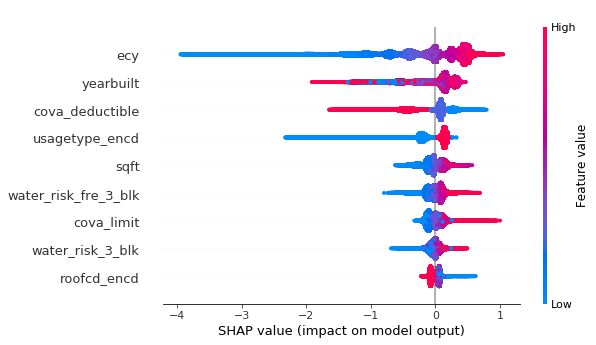

In [101]:
shap.summary_plot(shap_values_Classification, X_classification)

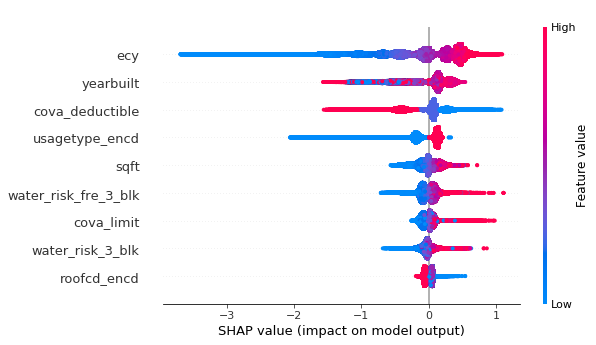

In [102]:
shap.summary_plot(shap_values_Poisson, X_poisson)

### Examine how changes in a feature change the model's prediction

The XGBoost model we trained above is very complicated, but by plotting the SHAP value for a feature against the actual value of the feature for all players we can see how changes in the feature's value effect the model's output. Note that these plots are very similar to standard partial dependence plots, but they provide the added advantage of displaying how much context matters for a feature (or in other words how much interaction terms matter). How much interaction terms effect the importance of a feature is capture by the vertical dispersion of the data points. For example earning only 100 gold/min during a game may lower your logg odds of winning by 10 for some players or only 3 for others. Why is this? Because other features of these players effect how much earning gold matters for winning the game. Note that the vertical spread narrows once you earn at least 500 gold/min, meaning the context of other features matters less for high gold earners than low gold earners. We color the datapoints with another feature that most explains the interaction effect variance. For example earning less gold is less bad if you have not died very much, but it is really bad if you also die a lot.

The y-axis in the plots below represents the SHAP value for that feature, so -4 means observing that feature lowers your log odds of winning by 4, while a value of +2 means observing that feature raises your log odds of winning by 2.

Note that these plot just explain how the XGBoost model works, not nessecarily how reality works. Since the XGBoost model is trained from observational data, it is not nessecarily a causal model, and so just because changing a factor makes the model's prediction of winning go up, does not always mean it will raise your actual chances.

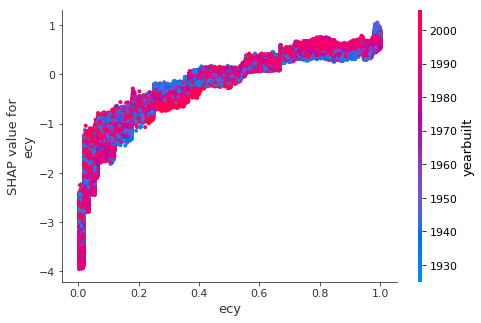

In [103]:
shap.dependence_plot('ecy', shap_values_Classification, X_classification, interaction_index='yearbuilt')

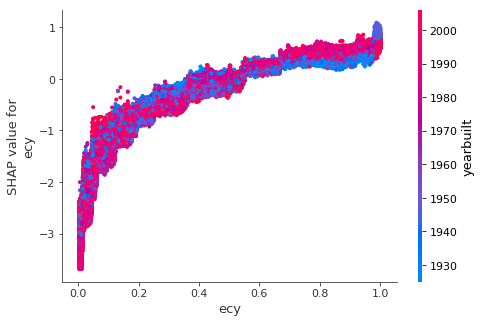

In [104]:
shap.dependence_plot('ecy', shap_values_Poisson, X_poisson, interaction_index='yearbuilt')

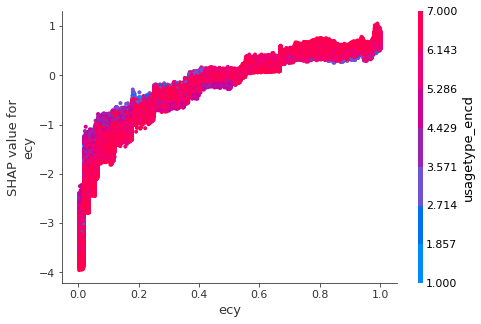

In [105]:
shap.dependence_plot('ecy', shap_values_Classification, X_classification, interaction_index='usagetype_encd')

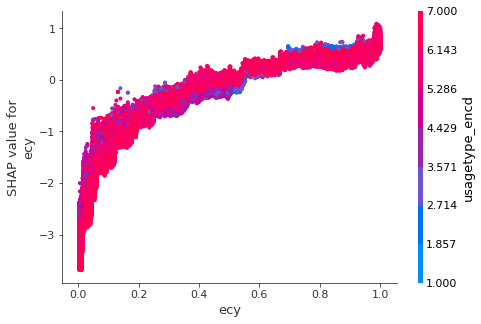

In [106]:
shap.dependence_plot('ecy', shap_values_Poisson, X_poisson, interaction_index='usagetype_encd')

    when usagetype='PRIMARY' then 7                                                                                        
    when usagetype='RENTAL' then 6                                                                                        
    when usagetype='COC' then 5                                                                                        
    when usagetype='VACANT' then 4                                                                                        
    when usagetype='SEASONAL' then 3                                                                                        
    when usagetype='SECONDARY' then 2                                                                                        
    when usagetype='UNOCCUPIED' then 1 

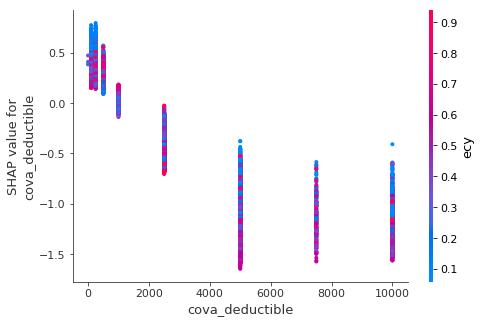

In [107]:
shap.dependence_plot('cova_deductible', shap_values_Classification, X_classification, interaction_index='ecy')

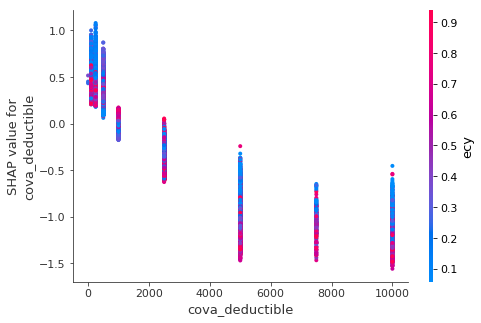

In [108]:
shap.dependence_plot('cova_deductible', shap_values_Poisson, X_poisson, interaction_index='ecy')

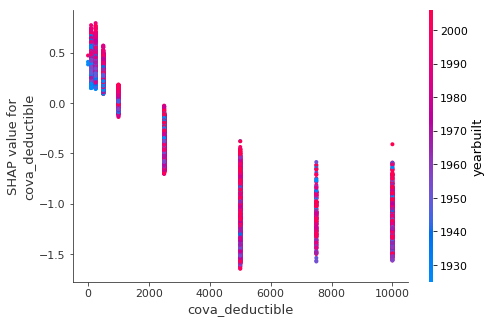

In [109]:
shap.dependence_plot('cova_deductible', shap_values_Classification, X_classification, interaction_index='yearbuilt')

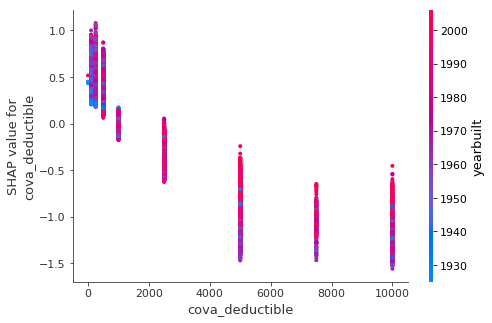

In [110]:
shap.dependence_plot('cova_deductible', shap_values_Poisson, X_poisson, interaction_index='yearbuilt')

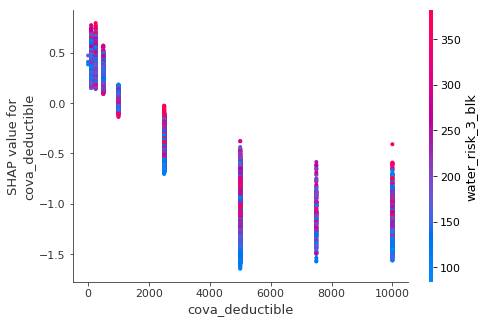

In [111]:
shap.dependence_plot('cova_deductible', shap_values_Classification, X_classification, interaction_index='water_risk_3_blk')

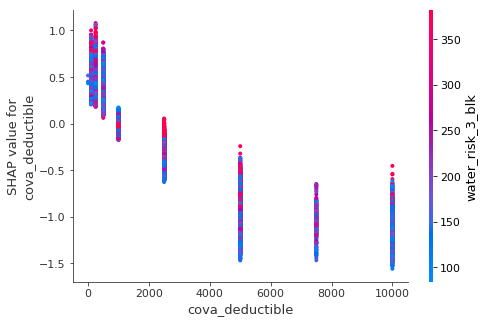

In [112]:
shap.dependence_plot('cova_deductible', shap_values_Poisson, X_poisson, interaction_index='water_risk_3_blk')

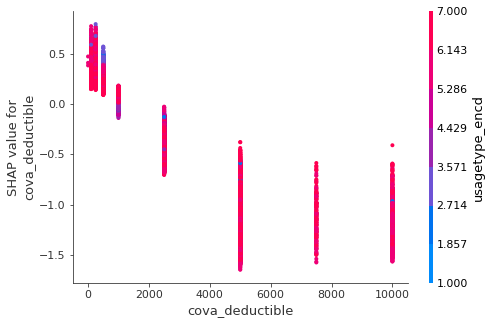

In [113]:
shap.dependence_plot('cova_deductible', shap_values_Classification, X_classification, interaction_index='usagetype_encd')

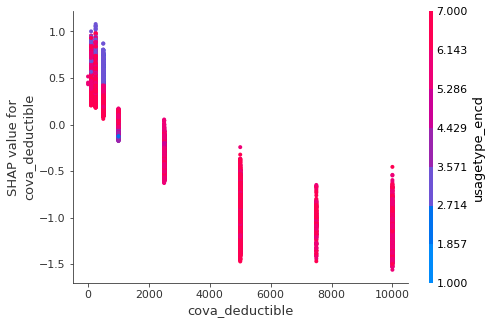

In [114]:
shap.dependence_plot('cova_deductible', shap_values_Poisson, X_poisson, interaction_index='usagetype_encd')

    when usagetype='PRIMARY' then 7                                                                                        
    when usagetype='RENTAL' then 6                                                                                        
    when usagetype='COC' then 5                                                                                        
    when usagetype='VACANT' then 4                                                                                        
    when usagetype='SEASONAL' then 3                                                                                        
    when usagetype='SECONDARY' then 2                                                                                        
    when usagetype='UNOCCUPIED' then 1 

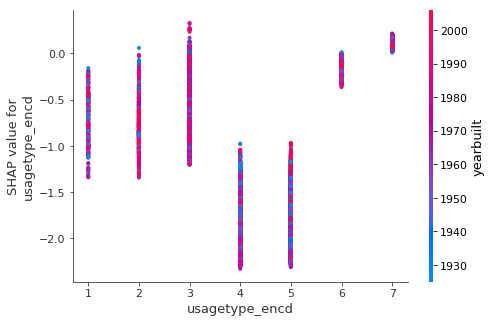

In [115]:
shap.dependence_plot('usagetype_encd', shap_values_Classification, X_classification, interaction_index='yearbuilt')

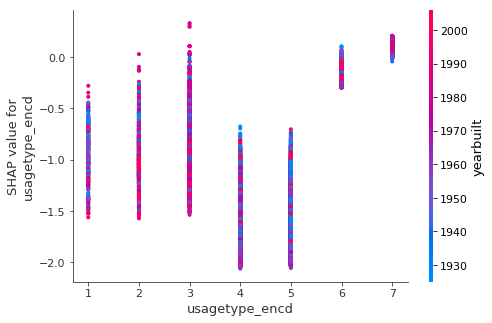

In [116]:
shap.dependence_plot('usagetype_encd', shap_values_Poisson, X_poisson, interaction_index='yearbuilt')

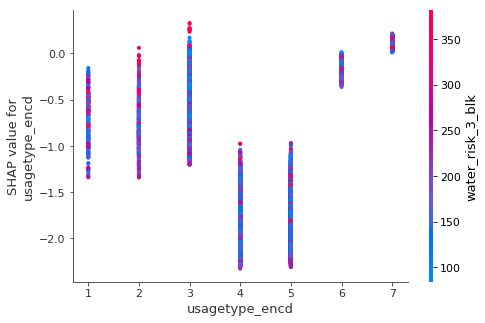

In [117]:
shap.dependence_plot('usagetype_encd', shap_values_Classification, X_classification, interaction_index='water_risk_3_blk')

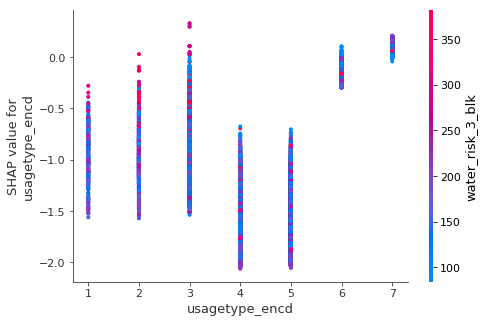

In [118]:
shap.dependence_plot('usagetype_encd', shap_values_Poisson, X_poisson, interaction_index='water_risk_3_blk')

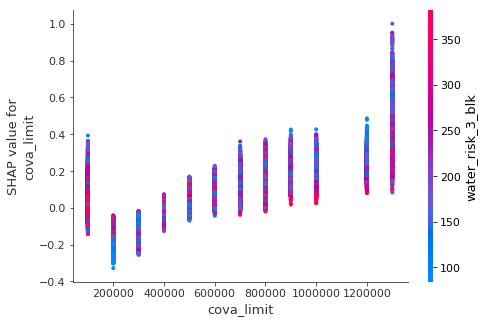

In [119]:
shap.dependence_plot('cova_limit', shap_values_Classification, X_classification, interaction_index='water_risk_3_blk')

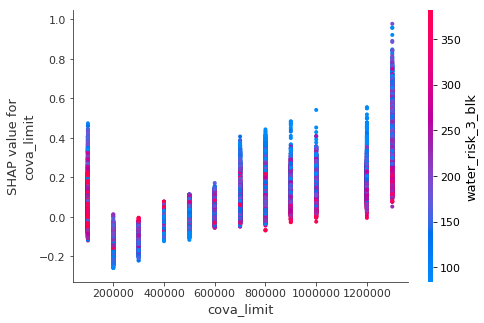

In [120]:
shap.dependence_plot('cova_limit', shap_values_Poisson, X_poisson, interaction_index='water_risk_3_blk')